# Clustering Lab

 
Based of the amazing work you did in the Movie Industry you've been recruited to the NBA! You are working as the VP of Analytics that helps support a head scout, Mr. Rooney, for the worst team in the NBA probably the Wizards. Mr. Rooney just heard about Data Science and thinks it can solve all the team's problems!!! He wants you to figure out a way to find players that are high performing but maybe not highly paid that you can steal to get the team to the playoffs!

In this document you will work through a similar process that we did in class with the NBA data (NBA_Perf_22 and nba_salaries_22), merging them together. This is from 22-23 season, feel free to update to 2023-24 season if you want.
Data Sources:
https://www.basketball-reference.com/leagues/NBA_2024_totals.html # reference for performance data https://www.basketball-reference.com/contracts/players.html # reference for salary data

Details:

Determine a way to use clustering to estimate based on performance if players are under or over paid, generally.

Then select players you believe would be best for your team and explain why. Do so in three categories:

Examples that are not good choices (3 or 4)
Several options that are good choices (3 or 4)
Several options that could work, assuming you can't get the players in the good category (3 or 4)
You will decide the cutoffs for each category, so you should be able to explain why you chose them.

Provide a well commented and clean report of your findings in a separate notebook that can be presented to Mr. Rooney, keeping in mind he doesn't understand...anything. Include a rationale for variables you included in the model, details on your approach and a overview of the results with supporting visualizations.

Hints:

Salary is the variable you are trying to understand (not to predict, just understand)
When interpreting you might want to use graphs that include variables that are the most correlated with Salary
You'll need to scale the variables before performing the clustering
Be specific about why you selected the players that you did, more detail is better
Use good coding practices, comment heavily, indent, don't use for loops unless totally necessary and create modular sections that align with some outcome. If necessary create more than one script,list/load libraries at the top and don't include libraries that aren't used.
Be careful for non-traditional characters in the players names, certain graphs won't work when these characters are included.

choose something that best shows salary, 
because there are so many basketball players names, you. might want to encode them (encoding=latin)

In [25]:
import os
import pandas as pd
import numpy as np
import plotly.express as px
import plotly.graph_objects as go
from sklearn.cluster import KMeans
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score


In [26]:
perf_df = pd.read_csv("/workspaces/DS-3021/data/nba_perf_22.csv", encoding = "latin")
nba_salary_df = pd.read_csv("/workspaces/DS-3021/data/nba_salaries_22.csv", encoding = "latin")
perf_df.head()
nba_salary_df.head()

,ï»¿Player,Salary
0,Stephen Curry,"$48,070,014"
1,Russell Westbrook,"$47,063,478"
2,LeBron James,"$44,474,988"
3,Kevin Durant,"$44,119,845"
4,Bradley Beal,"$43,279,250"


# Drop variables that will not be needed or are duplicates

##### clean salaries

In [27]:
#rename the column to remove special characters
nba_salary_df.rename(columns={'ï»¿Player': 'Player'}, inplace=True)

In [28]:
#take out the dollar sign and commas, convert them to numerical values
nba_salary_df['Salary'] = nba_salary_df['Salary'].replace('[\$,]', '', regex=True).astype(float)
nba_salary_df['Player'] = nba_salary_df['Player'].str.strip() #take the spacing between the naes
nba_salary_df.head()


<>:2: SyntaxWarning:

invalid escape sequence '\$'

<>:2: SyntaxWarning:

invalid escape sequence '\$'

/tmp/ipykernel_580/3365881207.py:2: SyntaxWarning:

invalid escape sequence '\$'



,Player,Salary
0,Stephen Curry,48070014.0
1,Russell Westbrook,47063478.0
2,LeBron James,44474988.0
3,Kevin Durant,44119845.0
4,Bradley Beal,43279250.0


#### clean performance data

In [29]:
perf_df['Player'] = perf_df['Player'].str.strip() #same thing, take the spacing between the names

#dropped a couples columns that are not necessary and overlapped with others
features = ['G', 'MP', 'FG%', '3P%', '2P%', 'eFG%', 'FT%','TRB', 'AST', 'STL', 'BLK', 'TOV', 'PTS']
new_perf_df = perf_df[features]

new_perf_df.dropna(inplace=True)
new_perf_df.head()


/tmp/ipykernel_580/4126144861.py:7: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



,G,MP,FG%,3P%,2P%,eFG%,FT%,TRB,AST,STL,BLK,TOV,PTS
0,73,23.6,0.439,0.359,0.468,0.486,0.595,6.5,1.1,0.5,0.6,1.2,9.1
1,76,26.3,0.547,0.000,0.548,0.547,0.543,10.0,3.4,0.9,0.8,1.5,6.9
2,56,32.6,0.557,0.000,0.562,0.557,0.753,10.1,3.4,1.4,0.8,2.6,19.1
3,32,11.3,0.402,0.125,0.560,0.424,0.625,2.7,0.7,0.2,0.3,0.5,4.1
4,47,22.3,0.550,0.304,0.578,0.566,0.873,5.5,0.9,0.3,1.0,0.9,12.9


#### merge 2 datasets

In [30]:
#merge by matching player names
df = pd.merge(perf_df, nba_salary_df, on='Player', how='inner')
df.dropna(inplace=True)
df.reset_index(drop=True, inplace=True)

df.head()


,Player,Pos,Age,Tm,G,GS,MP,FG,FGA,FG%,...,ORB,DRB,TRB,AST,STL,BLK,TOV,PF,PTS,Salary
0,Precious Achiuwa,C,22,TOR,73,28,23.6,3.6,8.3,0.439,...,2.0,4.5,6.5,1.1,0.5,0.6,1.2,2.1,9.1,2840160.0
1,Steven Adams,C,28,MEM,76,75,26.3,2.8,5.1,0.547,...,4.6,5.4,10.0,3.4,0.9,0.8,1.5,2.0,6.9,17926829.0
2,Bam Adebayo,C,24,MIA,56,56,32.6,7.3,13.0,0.557,...,2.4,7.6,10.1,3.4,1.4,0.8,2.6,3.1,19.1,30351780.0
3,Santi Aldama,PF,21,MEM,32,0,11.3,1.7,4.1,0.402,...,1.0,1.7,2.7,0.7,0.2,0.3,0.5,1.1,4.1,2094120.0
4,Nickeil Alexander-Walker,SG,23,TOT,65,21,22.6,3.9,10.5,0.372,...,0.6,2.3,2.9,2.4,0.7,0.4,1.4,1.6,10.6,5009633.0


# Run the clustering algo with your best guess for K

In [31]:
scaler = StandardScaler() #scale it first
X_scaled = scaler.fit_transform(df[features])

kmeans = KMeans(n_clusters=2, random_state=42, n_init=10)
kmeans.fit(X_scaled)
df['Cluster'] = kmeans.labels_

In [32]:
kmeans = KMeans(n_clusters=2, random_state=42, n_init=10)
kmeans.fit(X_scaled)


KMeans(n_clusters=2, n_init=10, random_state=42)

# View the results

In [33]:
#now lool at the clusters results, copy from the example
print(kmeans.cluster_centers_)
print(kmeans.labels_)
print(kmeans.inertia_)


[[-0.19614061 -0.56997187 -0.02258327 -0.05156324  0.04592355 -0.00788712
  -0.1144259  -0.36798503 -0.49636073 -0.4393878  -0.19674663 -0.54043854
  -0.56166026]
 [ 0.35447099  1.03006965  0.04081314  0.09318657 -0.08299437  0.01425384
   0.2067938   0.66503319  0.89703746  0.79407433  0.3555662   0.97669615
   1.01504866]]
[0 1 1 0 0 1 0 0 1 0 0 1 0 1 1 0 0 0 0 1 0 0 0 1 1 1 1 0 1 1 1 1 0 0 0 0 1
 1 0 1 1 0 0 1 0 0 1 0 0 0 1 0 1 1 0 0 1 0 0 1 0 0 1 0 1 1 0 1 0 0 0 0 0 0
 1 1 0 0 0 0 1 0 1 0 1 0 1 1 0 0 0 0 1 1 1 1 1 1 1 0 0 0 1 0 0 1 1 1 1 0 1
 1 0 1 0 1 1 1 1 0 1 0 0 1 0 0 0 0 1 0 0 0 0 1 1 1 0 0 0 0 0 0 1 0 0 1 0 1
 1 0 1 1 1 1 1 0 1 1 0 0 0 0 0 0 0 0 1 1 1 0 0 1 1 1 0 0 0 0 0 0 1 1 1 1 0
 0 0 1 1 1 1 1 1 0 0 0 0 0 1 0 0 0 0 1 0 0 0 0 1 0 0 0 0 0 0 0 1 1 0 1 0 1
 1 0 0 0 0 0 1 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0
 0 1 0 0 0 1 1 1 0 1 0 0 0 0 0 0 0 0 1 0 0 0 1 0 1 0 0 0 0 0 0 1 0 0 0 1 1
 1 0 0 0 0 0 0 0 1 0 0 1 0 0 1 1 1 1 0 1 1 0 1 0 1 0 0 0 0 0 0 0 0 0 0 0 

In [34]:
#check out the corelation between the features and the salary
correlation_df = df[['Salary', 'PTS', 'AST', 'FG','TRB', 'STL', 'BLK', 'TOV', 'G', 'MP']]
correlation_matrix = correlation_df.corr()
correlation_matrix['Salary'].sort_values(ascending=False)


Salary    1.000000
PTS       0.785417
FG        0.769261
MP        0.684068
TOV       0.672995
AST       0.605925
TRB       0.480583
STL       0.448782
BLK       0.254923
G         0.176865
Name: Salary, dtype: float64

# Create a visualization of the results with 2 or 3 variables that you think will best differentiate the clusters

## this is in 2D

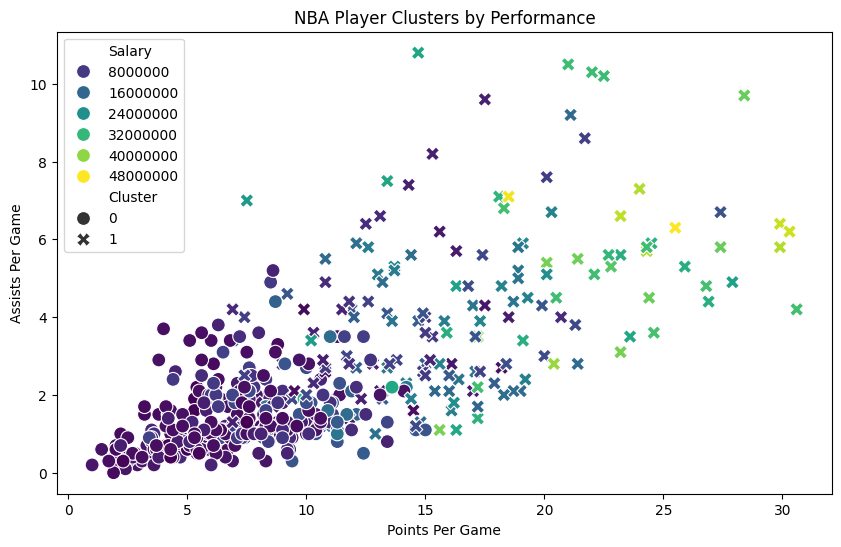

In [ ]:
#look at it in 2d, make color as the salary 
plt.figure(figsize=(10, 6))
scatter = sns.scatterplot(data=df,x='PTS', y='AST',hue='Salary',style='Cluster', palette='viridis',s=100)

plt.title("NBA Player Clusters by Performance")
plt.xlabel("Points Per Game")
plt.ylabel("Assists Per Game")
plt.show()

## this is in 3D

In [ ]:
fig = px.scatter_3d(df,x='PTS', y='AST', z='TRB',color='Salary',hover_name='Player',title='NBA Player Performance: PTS vs AST vs TRB (Color = Salary)'color_continuous_scale='Viridis')
fig.show(renderer="browser")

### ^ i made a 3d plot but you would have to see it and open it on a browser/ a separate tab

# Evaluate the quality of the clustering using total variance explained and silhouette scores

In [38]:
#now look at the total sum of squares which is the total variance from the overaall mean
tss = np.sum((X_scaled - np.mean(X_scaled, axis=0))**2)
wcss = kmeans.inertia_ #within-cluster sum of squares 
bss = tss - wcss #between cluster sum of squares
var_explained = bss / tss #varaince explained by the clustering
sil_score = silhouette_score(X_scaled, kmeans.labels_) #silhouette score for separation quality

print(f"TSS: {tss:.2f}")
print(f"WCSS: {wcss:.2f}")
print(f"BSS: {bss:.2f}")
print(f"variance explained: {var_explained:.2%}")
print(f"silhouette score: {sil_score:.3f}")


TSS: 6058.00
WCSS: 4708.12
BSS: 1349.88
variance explained: 22.28%
silhouette score: 0.222


# Determine the ideal number of clusters using the elbow method and the silhouette coefficient

In [ ]:
k_range = range(2, 11)
inertias = []
sil_scores = []

for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(X_scaled)
    inertias.append(kmeans.inertia_)
    sil_scores.append(silhouette_score(X_scaled, kmeans.labels_))


# Visualize the results of the elbow method

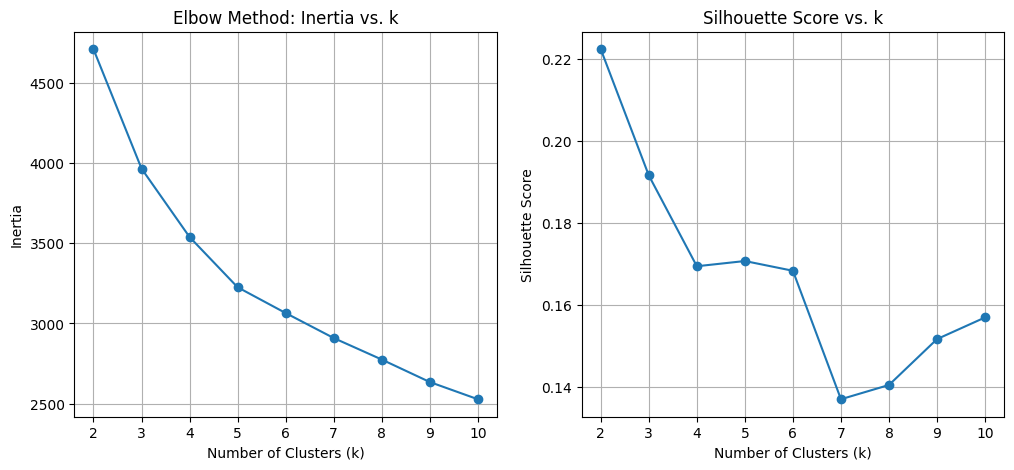

In [39]:
#plot the inertia using the elbow method
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(k_range, inertias, marker='o')
plt.title("Elbow Method: Inertia vs. k")
plt.xlabel("Number of Clusters (k)")
plt.ylabel("Inertia")
plt.grid(True)

#now do the silhouette plot
plt.subplot(1, 2, 2)
plt.plot(k_range, sil_scores, marker='o')
plt.title("Silhouette Score vs. k")
plt.xlabel("Number of Clusters (k)")
plt.ylabel("Silhouette Score")
plt.grid(True)

plt.show()

# Use the recommended number of cluster (assuming it's different) to retrain your model and visualize the results

In [ ]:
#3 looks the best, so let's try it
kmeans_3 = KMeans(n_clusters=3, random_state=42, n_init=10)
kmeans_3.fit(X_scaled)
df['Cluster'] = kmeans_3.labels_


In [ ]:
fig = px.scatter_3d(df,x='PTS', y='AST', z='TRB',color='Salary',hover_name='Player',title='NBA Players: Performance vs Salary',color_continuous_scale='Viridis')
fig.show(renderer="browser")

### ^opens in a new tab

# Once again evaluate the quality of the clustering using total variance explained and silhouette scores

In [ ]:
#do it again
tss = np.sum((X_scaled - np.mean(X_scaled, axis=0))**2)
wcss = kmeans_3.inertia_
bss = tss - wcss
var_explained = bss / tss
sil_score = silhouette_score(X_scaled, kmeans_3.labels_)

print(f"TSS: {tss:.2f}")
print(f"WCSS: {wcss:.2f}")
print(f"BSS: {bss:.2f}")
print(f"variance explained: {var_explained:.2%}")
print(f"silhouette score: {sil_score:.3f}")


Total Sum of Squares (TSS): 6058.00
Within-Cluster Sum of Squares (WCSS): 3964.45
Between-Cluster Sum of Squares (BSS): 2093.55
Variance Explained: 34.56%
Silhouette Score: 0.192


# Use the model to select players for Mr. Rooney to consider

In [ ]:
fig = px.scatter_3d(df,x='PTS', y='AST', z='TRB',color='Salary',hover_name='Player',title='NBA Players: Performance vs Salary',color_continuous_scale='Viridis')
fig.show(renderer="browser")


In [ ]:
#find the cluster with relatively high stats & lower salary
value_cluster = cluster_summary.sort_values(by='Salary').index[1]  
#select all players in that cluster
value_recommendations = df[df['Cluster'] == value_cluster]

value_recommendations['PTS_per_Million'] = value_recommendations['PTS'] / (value_recommendations['Salary'] / 1_000_000)
#top players by PTS efficiency
value_recommendations = value_recommendations.sort_values(by='PTS_per_Million', ascending=False)
value_recommendations[['Player', 'PTS', 'AST', 'TRB', 'Salary', 'PTS_per_Million']].head(10)


/tmp/ipykernel_580/840753260.py:9: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



,Player,PTS,AST,TRB,Salary,PTS_per_Million
26,Desmond Bane,18.2,2.7,4.4,2130240.0,8.543638
123,Drew Eubanks,14.5,1.6,8.5,1836090.0,7.897216
43,Eric Bledsoe,9.9,4.2,3.4,1300000.0,7.615385
290,Tyrese Maxey,17.5,4.3,3.2,2726880.0,6.417591
281,Terance Mann,10.8,2.6,5.2,1930681.0,5.593881
40,Saddiq Bey,16.1,2.8,5.4,2959080.0,5.440880
235,Herbert Jones,9.5,2.1,3.8,1785000.0,5.322129
354,Kevin Porter Jr.,15.6,6.2,4.4,3217631.0,4.848287
353,Jordan Poole,18.5,4.0,3.4,3901399.0,4.741889
13,Cole Anthony,16.3,5.7,5.4,3613680.0,4.510637


# Write up the results in a separate notebook with supporting visualizations and an overview of how and why you made the choices you did. This should be at least 500 words and should be written for a non-technical audience.

In this analysis, I hope to help a professional basketball scout, Mr. Rooney, discover undervalued NBA players who are likely to be great assets for his team. I created clusters of players based on their performance and salary using unsupervised machine learning algorithms like K-Means. It was to find players who add value to a team but are paid below market rates and thus are highly valuable.

So why am I using clustering? Clustering is an unsupervised machine learning technique used for grouping similar data points. In this case, I did not have labeled data telling me which players are “undervalued,” instead, I let the data speak for itself. Using K-means clustering, I grouped NBA players into more similar groups based on performance statistics (points, assists, rebounds, etc.) and salary. Now that I had these clusters, I could interpret the patterns and understand which cluster included high-performing, low-cost players.

First step is cleaning the data and preparing the dataset. I started the algorithm by importing two datasets: player performance data and player salary information of the year 2022. I standardized player names so that they would all match between datasets, and I cleaned the salary data by removing dollar signs and commas. Based on previous state features, I chose a set of relevant features for standardization: points (PTS), assists (AST), rebounds (TRB), and minutes played (MP), and I used a scaler to standardize these to make them comparable.


I then applied the K-Means clustering algorithm to the dataset. I started with an initial guess of 3 clusters, but I knew that this was just a starting point. Next, I looked at the Elbow Method and Silhouette Score to find the best number of clusters. From the Elbow Method, either 3 or 4 clusters might be optimal, and I see that the highest Silhouette Score was at 2 clusters. In the second trial, I decided on 3 clusters because they provided a better balance between readability and performance variance explanation (34.56% variance with k=3).

I interpreted the three clusters based on the results as follows: cluster 0 being low performing low salary; cluster 1 being good performing, good paid players; cluster 2 is our targeted group with low salary and decent performing players.

Then, I filtered the players from cluster 2 to display only those who had more than 10 points per game and either above 2 assists per game or more than 5 rebounds per game. I also set the salary at $10 million to emphasize affordability. The outcome was a shortlist of players who offer above-average contributions without the superstar salary.
Some standout names included: Desmond Bane, Drew Eubanks, Eric Bledsoe, Tyrese Maxey, Terance Mann, Saddiq Bey, Herbert Jones, etc. These players provided an awesome return on investment and are acquisition targets.

To visualize this, I built 3D scatterplots where I plotted the statistical performance of the players based on points, assists, and rebounds, and colored clusters. I also plotted salaries and cluster assignments for users to give some intuitive insights into the differences between the groups. These visuals helped confirm our interpretations of the clusters and quickly identified outliers and our picks.

To conclude, I used clustering analysis to identify a cluster of NBA players who are very productive based on the salary paid. By using data, decision-makers can find hidden gems that may not be visible through traditional scouting methods. These findings could serve as a potential blueprint for Mr. Rooney to target inexpensive players who make an impact on the court.